In [1]:
# ขั้นตอนที่ 1 ติดตั้งไลบรารีที่จำเป็น

In [2]:
!pip install osmnx==1.9.1 folium -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 2.0 MB/s eta 0:00:00


In [3]:
# ขั้นตอนที่ 2 Import และตั้งค่าพื้นฐาน

In [5]:
import osmnx as ox
import networkx as nx
import folium
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

In [6]:
ox.settings.use_cache = True
ox.settings.log_console = False

In [7]:
print(f"OSMnx version: {ox.__version__}")
print(f"NetworkX version: {nx.__version__}")

OSMnx version: 1.9.1
NetworkX version: 3.5


In [8]:
# ขั้นตอนที่ 3 ดึงข้อมูลแผนที่กรุงเทพฯ

In [9]:
place_name = "Chatuchak, Bangkok, Thailand"

- Nodes (intersections): 4,313
- Edges (street segments): 9,450


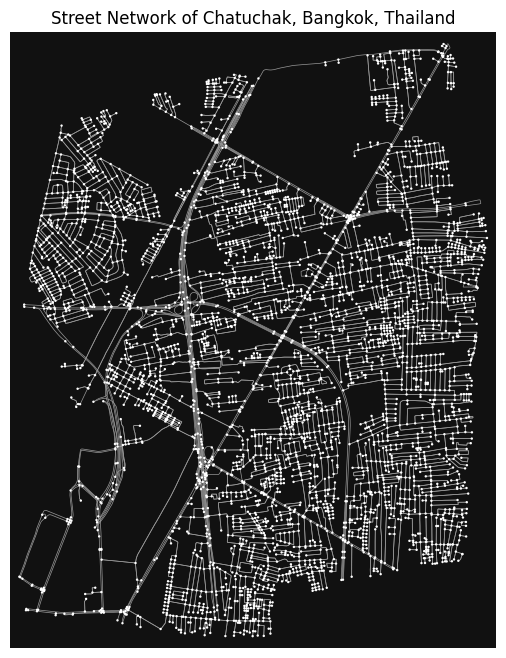

In [15]:
try:
    # ดึงข้อมูลเครือข่ายถนนสำหรับการขับรถ
    G = ox.graph_from_place(place_name, network_type='drive')

    print(f"- Nodes (intersections): {G.number_of_nodes():,}")
    print(f"- Edges (street segments): {G.number_of_edges():,}")

    fig, ax = ox.plot_graph(G, node_size=3.0, edge_linewidth=0.5, show=False, close=False)
    plt.title(f"Street Network of {place_name}")
    plt.show()

except Exception as e:
    print(f"Error downloading map data: {e}")

In [12]:
# ขั้นตอนที่ 4 สำรวจข้อมูลเบื้องต้น

In [13]:
edges = ox.graph_to_gdfs(G, nodes=False)

print("🔍 Sample street data (first 5 streets):")
print(edges[['highway', 'length', 'name']].head())

print("\n📊 Types of roads in our graph:")
highway_counts = edges['highway'].value_counts()
print(highway_counts.head(10))

🔍 Sample street data (first 5 streets):
                                highway    length                  name
u         v          key                                               
85753778  1893839406 0    motorway_link   572.918                   NaN
          360294655  0         motorway  1619.557  ทางยกระดับอุตราภิมุข
105838415 1817818994 0          primary    91.289         ถนนงามวงศ์วาน
          8107214608 0      residential    58.344                   NaN
105838423 1647169498 0          primary    34.816         ถนนงามวงศ์วาน

📊 Types of roads in our graph:
highway
residential      8231
tertiary          331
trunk             176
primary           156
secondary         150
trunk_link        117
unclassified      101
primary_link       98
motorway_link      32
motorway           17
Name: count, dtype: int64


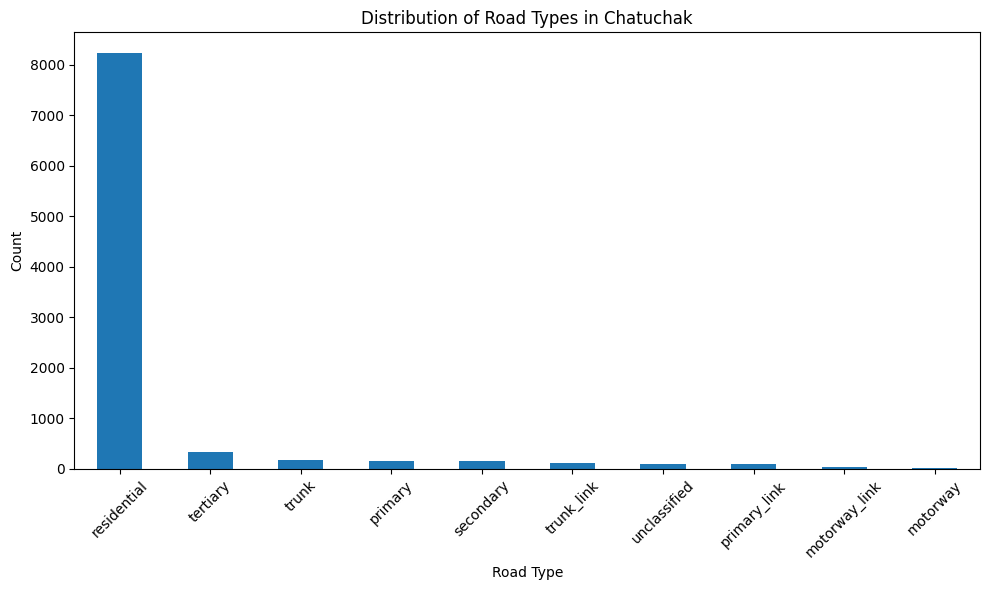

In [14]:
plt.figure(figsize=(10, 6))
highway_counts.head(10).plot(kind='bar')
plt.title("Distribution of Road Types in Chatuchak")
plt.xlabel("Road Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# ขั้นตอนที่ 5 กำหนดจุดเริ่มต้นและปลายทาง

In [16]:
start_lat, start_lon = 13.8021, 100.5538
start_name = "MRT Chatuchak Park"

In [17]:
end_lat, end_lon = 13.7992, 100.5489
end_name = "Or Tor Kor Market"

In [19]:
#  หาโหนดที่ใกล้ที่สุดบนกราฟ
orig_node = ox.nearest_nodes(G, start_lon, start_lat)
dest_node = ox.nearest_nodes(G, end_lon, end_lat)

print(f"🚶 Starting point: {start_name}")
print(f"   Node ID: {orig_node}")
print(f"🎯 Destination: {end_name}")
print(f"   Node ID: {dest_node}")

🚶 Starting point: MRT Chatuchak Park
   Node ID: 9444510080
🎯 Destination: Or Tor Kor Market
   Node ID: 2197616325


In [20]:
if nx.has_path(G, orig_node, dest_node):
    print("Path exists between origin and destination!")
else:
    print("No path found! Try different locations.")

Path exists between origin and destination!


In [21]:
# ขั้นตอนที่ 6 หาเส้นทางที่สั้นที่สุดด้วย A*

In [22]:
try:
    # ใช้ A* algorithm หาเส้นทางที่สั้นที่สุด (ตามระยะทาง)
    shortest_route = nx.astar_path(G, orig_node, dest_node, weight='length')

    # คำนวณระยะทางรวม
    route_length = nx.path_weight(G, shortest_route, weight='length')

    print(f"✅ Shortest route found!")
    print(f"📏 Total distance: {route_length:,.0f} meters ({route_length/1000:.2f} km)")
    print(f"🔢 Number of intersections: {len(shortest_route)}")

except nx.NetworkXNoPath:
    print("❌ No path found between these locations!")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Shortest route found!
📏 Total distance: 1,217 meters (1.22 km)
🔢 Number of intersections: 14


In [26]:
# ขั้นตอนที่ 7 แสดงผลเส้นทางบนแผนที่ Interactive

In [27]:
route_map = ox.plot_route_folium(G, shortest_route,
                                  route_color='red',
                                  route_width=5,
                                  route_opacity=0.8)

/tmp/ipython-input-27-562654551.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  route_map = ox.plot_route_folium(G, shortest_route,


In [28]:
start_marker = folium.Marker(
    location=[start_lat, start_lon],
    popup=f"<b>Start:</b> {start_name}",
    icon=folium.Icon(color='green', icon='play')
)
start_marker.add_to(route_map)

end_marker = folium.Marker(
    location=[end_lat, end_lon],
    popup=f"<b>End:</b> {end_name}",
    icon=folium.Icon(color='red', icon='stop')
)
end_marker.add_to(route_map)

In [29]:
print("🗺️ Interactive map (zoom in/out to explore):")
display(route_map)

🗺️ Interactive map (zoom in/out to explore):


In [30]:
# ขั้นตอนที่ 8 วิเคราะห์เส้นทาง

In [31]:
route_edges = ox.utils_graph.route_to_gdf(G, shortest_route, weight='length')

print("📊 Route Analysis:")
print(f"Total segments: {len(route_edges)}")
print(f"\n🛣️ Street names used:")

# รวบรวมชื่อถนนที่ใช้ (ไม่ซ้ำ)
street_names = route_edges['name'].dropna().unique()
for i, street in enumerate(street_names, 1):
    print(f"   {i}. {street}")

# แสดงประเภทถนนที่ใช้
print(f"\n🚗 Road types used:")
road_types = route_edges['highway'].value_counts()
for road_type, count in road_types.items():
    print(f"   - {road_type}: {count} segments")

📊 Route Analysis:
Total segments: 13

🛣️ Street names used:
   1. ถนนพหลโยธิน
   2. ถนนกำแพงเพชร
   3. ถนนกำแพงเพชร 2

🚗 Road types used:
   - secondary: 8 segments
   - trunk_link: 3 segments
   - trunk: 2 segments


In [ ]:
# ขั้นตอนที่ 9 ลองเปลี่ยนจุดปลายทาง

In [32]:
new_end_lat, new_end_lon = 13.8161, 100.5607
new_end_name = "Central Plaza Ladprao"

print(f"🎯 New destination: {new_end_name}")

🎯 New destination: Central Plaza Ladprao


In [33]:
new_dest_node = ox.nearest_nodes(G, new_end_lon, new_end_lat)
new_route = nx.astar_path(G, orig_node, new_dest_node, weight='length')
new_length = nx.path_weight(G, new_route, weight='length')

print(f"📏 Distance to new destination: {new_length:,.0f} meters ({new_length/1000:.2f} km)")
print(f"📊 Difference: {abs(new_length - route_length):,.0f} meters")

📏 Distance to new destination: 2,881 meters (2.88 km)
📊 Difference: 1,664 meters


In [34]:
comparison_map = ox.plot_route_folium(G, shortest_route,
                                      route_color='red',
                                      route_width=4,
                                      route_opacity=0.7)

comparison_map = ox.plot_route_folium(G, new_route,
                                      route_map=comparison_map,
                                      route_color='blue',
                                      route_width=4,
                                      route_opacity=0.7)

/tmp/ipython-input-34-2900661045.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  comparison_map = ox.plot_route_folium(G, shortest_route,
/tmp/ipython-input-34-2900661045.py:6: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  comparison_map = ox.plot_route_folium(G, new_route,


In [37]:
folium.Marker([start_lat, start_lon],
              popup=f"<b>Start:</b> {start_name}",
              icon=folium.Icon(color='green')).add_to(comparison_map)

folium.Marker([end_lat, end_lon],
              popup=f"<b>Destination 1:</b> {end_name}",
              icon=folium.Icon(color='red')).add_to(comparison_map)

folium.Marker([new_end_lat, new_end_lon],
              popup=f"<b>Destination 2:</b> {new_end_name}",
              icon=folium.Icon(color='blue')).add_to(comparison_map)

print("\n🗺️ Comparison map (Red = Or Tor Kor, Blue = Central Ladprao):")
display(comparison_map)


🗺️ Comparison map (Red = Or Tor Kor, Blue = Central Ladprao):


In [36]:
help(ox.graph_from_place)

Help on function graph_from_place in module osmnx.graph:

graph_from_place(query, network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, which_result=None, buffer_dist=None, clean_periphery=None, custom_filter=None)
    Download and create a graph within the boundaries of some place(s).
    
    The query must be geocodable and OSM must have polygon boundaries for the
    geocode result. If OSM does not have a polygon for this place, you can
    instead get its street network using the graph_from_address function,
    which geocodes the place name to a point and gets the network within some
    distance of that point.
    
    If OSM does have polygon boundaries for this place but you're not finding
    it, try to vary the query string, pass in a structured query dict, or vary
    the which_result argument to use a different geocode result. If you know
    the OSM ID of the place, you can retrieve its boundary polygon using the
    geocode_to_gdf function,

In [ ]:
# ขั้นตอนที่ 10 เพิ่ม "travel time" เป็น weight แทน distance

In [38]:
# Define estimated travel speeds for different road types in km/h
speed_kmph = {
    'residential': 30,  # Typical speed in residential areas
    'unclassified': 30, # Similar to residential
    'tertiary': 40,     # Medium speed urban roads
    'secondary': 50,    # Arterial roads
    'primary': 60,      # Major urban roads
    'trunk': 70,        # Major highways/expressways within urban area
    'motorway': 90,     # High-speed expressways
    'living_street': 10,# Very low speed
    'service': 20,      # Service roads, alleys
    'road': 30,         # General unclassified roads
    'primary_link': 60, # Links to primary roads
    'secondary_link': 50,# Links to secondary roads
    'tertiary_link': 40, # Links to tertiary roads
    'trunk_link': 70,   # Links to trunk roads
    'motorway_link': 90 # Links to motorways
}

print("Estimated speeds (km/h) by road type")
for highway_type, speed in speed_kmph.items():
    print(f"  {highway_type}: {speed}")

Estimated speeds (km/h) by road type
  residential: 30
  unclassified: 30
  tertiary: 40
  secondary: 50
  primary: 60
  trunk: 70
  motorway: 90
  living_street: 10
  service: 20
  road: 30
  primary_link: 60
  secondary_link: 50
  tertiary_link: 40
  trunk_link: 70
  motorway_link: 90


In [39]:
# ขั้นตอนที่ 11 คำนวน travel time

In [40]:
# Convert speed from km/h to meters per second
speed_mps = {highway_type: speed * 1000 / 3600 for highway_type, speed in speed_kmph.items()}

# Add 'speed_mps' attribute to edges based on 'highway' type
G = ox.add_edge_speeds(G, speed_mps)

# Calculate and add 'travel_time' attribute to edges
G = ox.add_edge_travel_times(G)

In [41]:
# ขั้นตอนที่ 12 shortest path จาก time

In [42]:
# ใช้ A* algorithm หาเส้นทางที่ใช้เวลาน้อยที่สุด
shortest_route_time = nx.astar_path(G, orig_node, dest_node, weight='travel_time')

# คำนวณเวลาการเดินทางรวม
route_time = nx.path_weight(G, shortest_route_time, weight='travel_time')

print(f"⏰ Estimated total travel time: {route_time:.2f} seconds ({route_time/60:.2f} minutes)")
print(f"Number of intersections: {len(shortest_route_time)}")

⏰ Estimated total travel time: 263.30 seconds (4.39 minutes)
Number of intersections: 14


In [43]:
# ตัวอย่างการกำหนดความเร็วให้แต่ละเส้นทาง

In [44]:
# u, v, key คือตัวระบุเส้นถนน และ 'speed_mps_actual' คือความเร็วจริงในหน่วย เมตรต่อวินาที
data = {
    'u': [85753778, 105838415, 105838415, 9444510080, 2197616325],
    'v': [1893839406, 1817818994, 8107214608, 2197616325, 9444510080],
    'key': [0, 0, 0, 0, 0],
    'speed_mps_actual': [15.2, 12.5, 5.0, 10.0, 9.5]
}

df_speeds_actual = pd.DataFrame(data)

display(df_speeds_actual)

,u,v,key,speed_mps_actual
0,85753778,1893839406,0,15.2
1,105838415,1817818994,0,12.5
2,105838415,8107214608,0,5.0
3,9444510080,2197616325,0,10.0
4,2197616325,9444510080,0,9.5
